<a href="https://colab.research.google.com/github/saraex6/Transfer-Learning-and-fine-tuning---VGG16-ResNet-50-Inception-V3-/blob/main/Resnet_50_Using_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mounting Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

# Define image transformations

In [3]:
BATCH_SIZE = 64
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) 

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) 


# Downloading the Dataset

In [4]:
train_data_dir = '/content/gdrive/MyDrive/Train'
test_data_dir = '/content/gdrive/MyDrive/Test'

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)


Found 1022 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


# Using pre-trained layers for feature extraction







In [5]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- we have 2 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional ResNet layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
                                                                             



In [6]:
#input shape of ResNet model
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=2

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE



In [7]:
pip install git+git://github.com/stared/livelossplot.git

  Cloning git://github.com/stared/livelossplot.git to /tmp/pip-req-build-zrb_12vt
  Running command git clone -q git://github.com/stared/livelossplot.git /tmp/pip-req-build-zrb_12vt


In [8]:
from livelossplot.tf_keras import PlotLossesCallback
from livelossplot.inputs.tf_keras import PlotLossesCallback

from livelossplot import PlotLossesKeras

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping: monitors the performance of the model and stopping the training process prevents overtraining
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


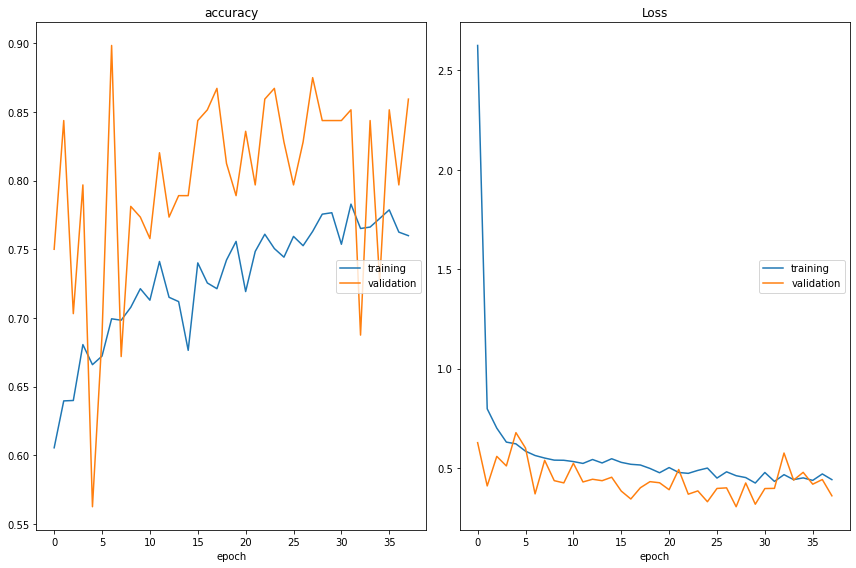

accuracy
	training         	 (min:    0.605, max:    0.783, cur:    0.760)
	validation       	 (min:    0.562, max:    0.898, cur:    0.859)
Loss
	training         	 (min:    0.424, max:    2.625, cur:    0.442)
	validation       	 (min:    0.305, max:    0.678, cur:    0.360)
15/15 [==============================] - 347s 23s/step - loss: 0.4415 - accuracy: 0.7599 - val_loss: 0.3602 - val_accuracy: 0.8594
CPU times: user 6h 3min 33s, sys: 3min 41s, total: 6h 7min 14s
Wall time: 3h 50min 19s


In [9]:
%%time 

# train the model 
ResNet_history = model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=50,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,                            
                            validation_steps=n_val_steps,
                            callbacks=[early_stop, plot_loss_1],
                            verbose=1)

In [10]:
# Generate predictions
#model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights


true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

ResNet_preds = model.predict(testgen)
ResNet_pred_classes = np.argmax(ResNet_preds, axis=1)


# Evaluate the performance of ResNet-50 using accuracy, F1 Score, precision, recall & loss metrics

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss

ResNet_acc = accuracy_score(true_classes, ResNet_pred_classes)
print("ResNet Model accuracy: {:.2f}%".format(ResNet_acc * 100))

ResNet_f1 = f1_score(true_classes, ResNet_pred_classes)
print("ResNet Model f1 score: {:.2f}%".format(ResNet_f1 * 100))

ResNet_precision_score = precision_score(true_classes, ResNet_pred_classes)
print("ResNet Model precision: {:.2f}%".format(ResNet_precision_score * 100))

ResNet_recall_score = recall_score(true_classes, ResNet_pred_classes)
print("ResNet Model recall: {:.2f}%".format(ResNet_recall_score * 100))

ResNet_log_loss = log_loss(true_classes, ResNet_pred_classes)
print("ResNet Model loss: {:.2f}%".format(ResNet_log_loss ))


ResNet Model accuracy: 85.85%
ResNet Model f1 score: 86.36%
ResNet Model precision: 83.33%
ResNet Model recall: 89.62%
ResNet Model loss: 4.89%


# Plot confusion matrix 

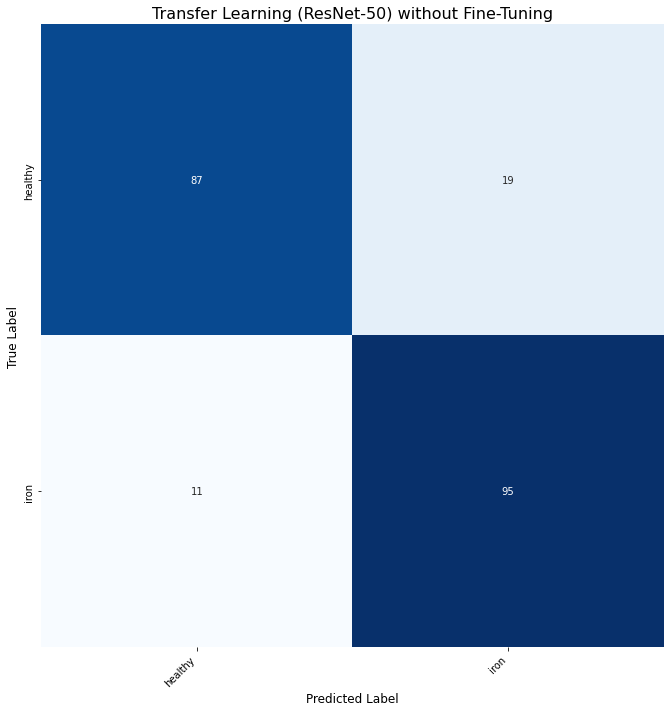

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

# Get the names of the classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax2) = plt.subplots(figsize=(20, 10))

plot_heatmap(true_classes, ResNet_pred_classes, class_names, ax2, title="Transfer Learning (ResNet-50) without Fine-Tuning")    

fig.tight_layout()

plt.show()
